# Лабораторная работа 3

## Импорт данных и библиотек

Импорт библиотек

In [ ]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.impute import MissingIndicator

from sklearn.preprocessing import LabelEncoder

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MaxAbsScaler

import re
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel

Импорт датасетов

In [ ]:
data = pd.read_csv("https://raw.githubusercontent.com/mansurik1/MMO2025_works/refs/heads/master/lw3/datasets/Air_Traffic_Passenger_Statistics.csv")

In [ ]:
data3_train = pd.read_csv("https://raw.githubusercontent.com/mansurik1/MMO2025_works/refs/heads/master/lw3/datasets/airline_passenger_satisfaction_80.csv")
data3_test = pd.read_csv("https://raw.githubusercontent.com/mansurik1/MMO2025_works/refs/heads/master/lw3/datasets/airline_passenger_satisfaction_20.csv")
data3 = pd.concat([data3_train, data3_test])

In [ ]:
data4 = pd.read_csv("https://raw.githubusercontent.com/mansurik1/MMO2025_works/refs/heads/master/lw3/datasets/EaseMyTrip_Flight%20_Fare_Travel_Listings.csv")

## Описание датасета Airline Passenger Satisfaction

В данном наборе, как и в наборе из предыдущей лабы (rynair_reviews) представлены оценки пассажиров о качестве разных характеристик рейса. Но в этом наборе, в отличие от предыдущего, есть и другие численные значения другой размерности, такие как дистанция полета, возраст пассажира, время задержки полета. Такой набор уже имеет смысл масштабировать, что и является одним из заданий данной лабораторной.

Целевой признак:

In [ ]:
data3_Y = data3["satisfaction"]
data3["satisfaction"].unique()

array(['neutral or dissatisfied', 'satisfied'], dtype=object)

Кодирование целевого признака:

In [ ]:
def encode_satisfaction_col(data):
  le_satisfaction = LabelEncoder()
  rec_le_satisfaction = le_satisfaction.fit_transform(data['satisfaction'])
  data['satisfaction'] = rec_le_satisfaction
  le_satisfaction.inverse_transform([0, 1])

encode_satisfaction_col(data3)
encode_satisfaction_col(data3_train)
encode_satisfaction_col(data3_test)

Категориальные признаки использовать не будем, поэтому сразу их уберем. Также уберем столбцы unnamed и id.

In [ ]:
cols_to_drop = [c for c in data3.columns if (data3[c].dtype == 'O')] + ['Unnamed: 0', 'id']
data3.drop(cols_to_drop, axis=1, inplace=True)
data3_train.drop(cols_to_drop, axis=1, inplace=True)
data3_test.drop(cols_to_drop, axis=1, inplace=True)

In [ ]:
data3.head()

,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,13,460,3,4,3,1,5,3,5,5,4,3,4,4,5,5,25,18.0,0
1,25,235,3,2,3,3,1,3,1,1,1,5,3,1,4,1,1,6.0,0
2,26,1142,2,2,2,2,5,5,5,5,4,3,4,4,4,5,0,0.0,1
3,25,562,2,5,5,5,2,2,2,2,2,5,3,1,4,2,11,9.0,0
4,61,214,3,3,3,3,4,5,5,3,3,4,4,3,3,3,0,0.0,1


Набор был взят из kaggle, где он уже был разделен на 2 части: обучающую (80%) и тестовую (20%) выборки.

In [ ]:
data3.shape, data3_train.shape, data3_test.shape

((129880, 19), (103904, 19), (25976, 19))

Обработка пропусков:

In [ ]:
def impute_column(dataset, column, strategy_param, fill_value_param=None):
    """
    Заполнение пропусков в одном признаке
    """
    temp_data = dataset[[column]].values
    size = temp_data.shape[0]

    indicator = MissingIndicator()
    mask_missing_values_only = indicator.fit_transform(temp_data)

    imputer = SimpleImputer(strategy=strategy_param,
                            fill_value=fill_value_param)
    all_data = imputer.fit_transform(temp_data)

    missed_data = temp_data[mask_missing_values_only]
    filled_data = all_data[mask_missing_values_only]

    return all_data.reshape((size,)), filled_data, missed_data

In [ ]:
data3_train["Arrival Delay in Minutes"] = impute_column(data3_train, "Arrival Delay in Minutes", 'median')[0]
data3_test["Arrival Delay in Minutes"] = impute_column(data3_test, "Arrival Delay in Minutes", 'median')[0]
data3["Arrival Delay in Minutes"] = impute_column(data3, "Arrival Delay in Minutes", 'median')[0]

Проверка, что пропусков нет:

In [ ]:
data3_train.isnull().sum().sum(), data3_test.isnull().sum().sum(), data3.isnull().sum().sum()

(0, 0, 0)

Набор без целевого признака:

In [ ]:
data3_without_satisfaction = data3.drop("satisfaction", axis=1)
data3_test_without_satisfaction = data3_test.drop("satisfaction", axis=1)
data3_train_without_satisfaction = data3_train.drop("satisfaction", axis=1)

Функция для восстановления датафрейма

In [ ]:
def arr_to_df(arr_scaled):
    res = pd.DataFrame(arr_scaled, columns=data3_without_satisfaction.columns)
    return res

## Масштабирование признаков

Будем использовать следующие методы:

ТАБЛИЦА

### Z-оценка

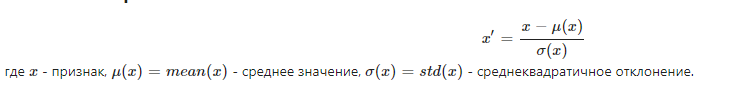

In [ ]:
cs11 = StandardScaler()
data_cs11_scaled_temp = cs11.fit_transform(data3_without_satisfaction)
data_cs11_scaled =  arr_to_df(data_cs11_scaled_temp)
data_cs11_scaled

,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes
0,-1.747961,-0.732184,0.204090,0.617265,0.173445,-1.546267,1.349867,-0.187037,1.181428,1.230787,0.479357,-0.266574,0.311762,0.547894,1.153946,1.304487,0.270187,0.076909
1,-0.954274,-0.957760,0.204090,-0.692719,0.173445,0.018048,-1.657814,-0.187037,-1.850520,-1.767616,-1.851475,1.252898,-0.535681,-1.821437,0.304086,-1.740402,-0.360214,-0.235460
2,-0.888133,-0.048440,-0.548166,-0.692719,-0.539957,-0.764109,1.349867,1.293662,1.181428,1.230787,0.479357,-0.266574,0.311762,0.547894,0.304086,1.304487,-0.386481,-0.391644
3,-0.954274,-0.629924,-0.548166,1.272257,1.600249,1.582364,-0.905894,-0.927386,-1.092533,-1.018015,-1.074531,1.252898,-0.535681,-1.821437,0.304086,-0.979180,-0.097547,-0.157368
4,1.426788,-0.978814,0.204090,-0.037727,0.173445,0.018048,0.597947,1.293662,1.181428,-0.268414,-0.297587,0.493162,0.311762,-0.241883,-0.545774,-0.217958,-0.386481,-0.391644
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129875,-0.359008,-0.666016,0.204090,-0.037727,0.173445,-1.546267,0.597947,-0.187037,0.423441,0.481186,-0.297587,-1.026310,0.311762,0.547894,1.153946,0.543264,-0.386481,-0.391644
129876,-1.086555,-0.545709,0.956346,0.617265,0.886847,0.800206,0.597947,0.553313,0.423441,0.481186,0.479357,1.252898,1.159206,1.337671,1.153946,0.543264,-0.386481,-0.391644
129877,-1.483399,-0.363243,-0.548166,1.272257,-1.253359,1.582364,-0.905894,-1.667736,-1.092533,-1.018015,0.479357,-0.266574,0.311762,1.337671,0.304086,-0.979180,-0.386481,-0.391644
129878,-1.681821,-0.063478,0.204090,-0.037727,0.173445,0.018048,0.597947,0.553313,0.423441,0.481186,-0.297587,-1.026310,1.159206,0.547894,1.153946,0.543264,-0.386481,-0.391644


Построение плотности распределения

In [ ]:
def draw_kde(col_list, df1, df2, label1, label2):
    fig, (ax1, ax2) = plt.subplots(
        ncols=2, figsize=(12, 5))
    # первый график
    ax1.set_title(label1)
    sns.kdeplot(data=df1[col_list], ax=ax1)
    # второй график
    ax2.set_title(label2)
    sns.kdeplot(data=df2[col_list], ax=ax2)
    plt.show()

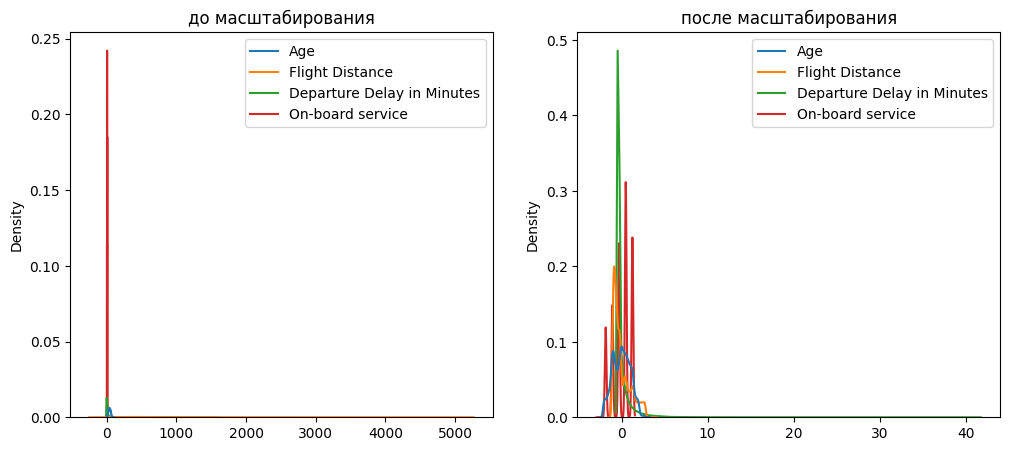

In [ ]:
draw_kde(['Age', 'Flight Distance', 'Departure Delay in Minutes', 'On-board service'], data3, data_cs11_scaled, 'до масштабирования', 'после масштабирования')

Как видим, на 1ом рисунке из-за отличий размерностей метрик их невозможно сравнить. На 2ом рисунке, после масштабирования, уже можем сравнивать признаки разных размерностей.

Теперь произведем масштабирование отдельно для тестовой и обучающей выборок. Обучать StandardScaler будем на обучающей выборке.

In [ ]:
cs12 = StandardScaler()
cs12.fit(data3_train_without_satisfaction)
data_cs12_scaled_train_temp = cs12.transform(data3_train_without_satisfaction)
data_cs12_scaled_test_temp = cs12.transform(data3_test_without_satisfaction)

data_cs12_scaled_train = arr_to_df(data_cs12_scaled_train_temp)
data_cs12_scaled_test = arr_to_df(data_cs12_scaled_test_temp)

Заметим, что распределения для тестовой и обучающей выборок немного отличаются:

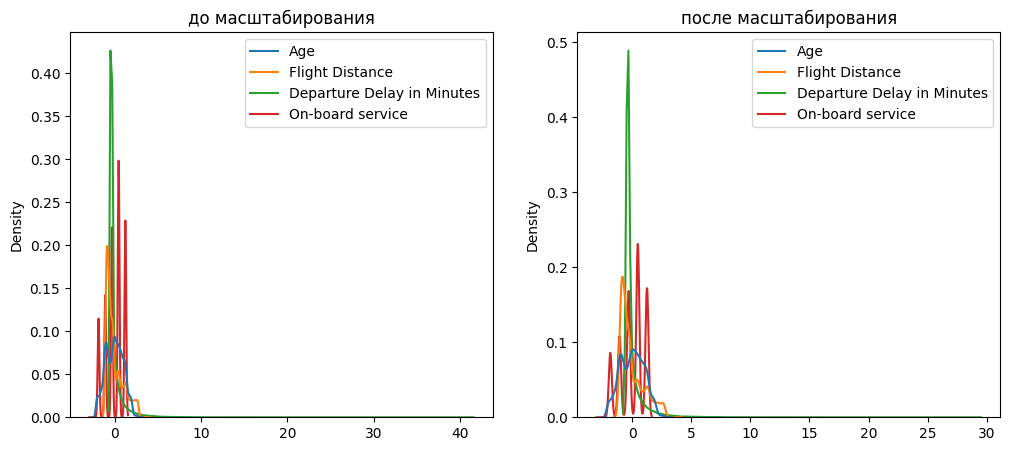

In [ ]:
draw_kde(['Age', 'Flight Distance', 'Departure Delay in Minutes', 'On-board service'], data_cs12_scaled_train, data_cs12_scaled_test, 'до масштабирования', 'после масштабирования')

### Масштабирование "Mean Normalisation"

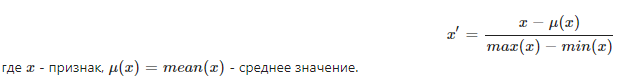

In [ ]:
class MeanNormalisation:
    def fit(self, param_df):
        self.means = data3_train_without_satisfaction.mean(axis=0)
        maxs = data3_train_without_satisfaction.max(axis=0)
        mins = data3_train_without_satisfaction.min(axis=0)
        self.ranges = maxs - mins

    def transform(self, param_df):
        param_df_scaled = (param_df - self.means) / self.ranges
        return param_df_scaled

    def fit_transform(self, param_df):
        self.fit(param_df)
        return self.transform(param_df)

In [ ]:
sc21 = MeanNormalisation()
data_cs21_scaled = sc21.fit_transform(data3_without_satisfaction)
#data_cs21_scaled.describe()

cs22 = MeanNormalisation()
cs22.fit(data3_train_without_satisfaction)
data_cs22_scaled_train = cs22.transform(data3_train_without_satisfaction)
data_cs22_scaled_test = cs22.transform(data3_test_without_satisfaction)

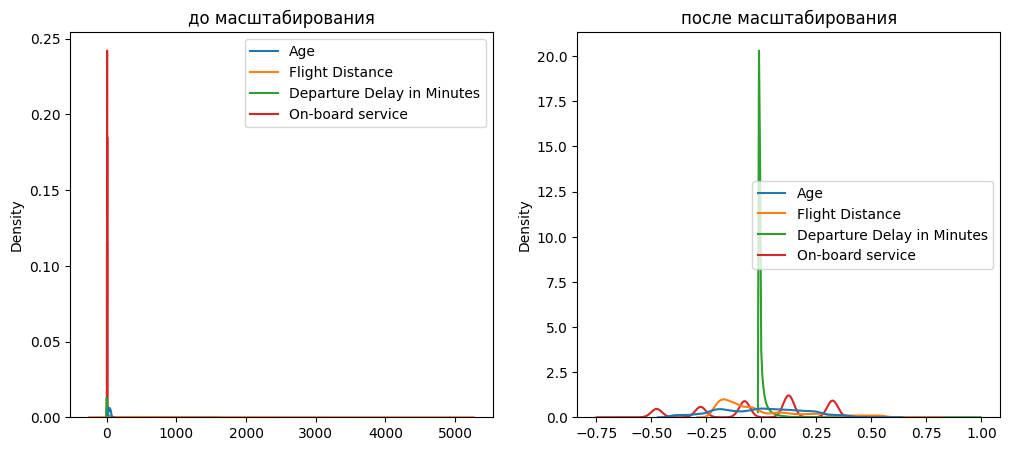

In [ ]:
draw_kde(['Age', 'Flight Distance', 'Departure Delay in Minutes', 'On-board service'], data3, data_cs21_scaled, 'до масштабирования', 'после масштабирования')

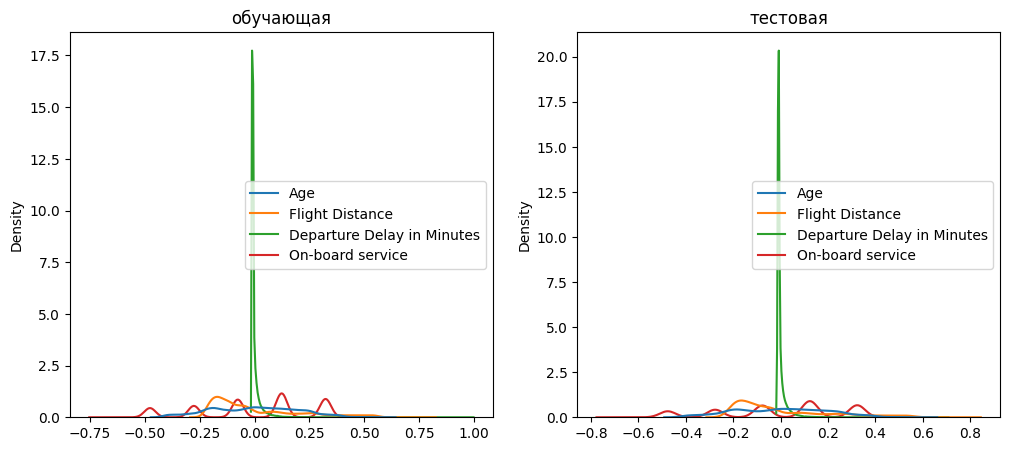

In [ ]:
draw_kde(['Age', 'Flight Distance', 'Departure Delay in Minutes', 'On-board service'], data_cs22_scaled_train, data_cs22_scaled_test, 'обучающая', 'тестовая')

Как видим, в этом методе форма распределения поменялась и значения лежат в интервале [-1, 1]. Это метод более удобен, чем предыдущий

### MinMax масштабирование

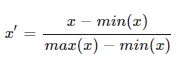

In [ ]:
cs31 = MinMaxScaler()
data_cs31_scaled_temp = cs31.fit_transform(data3_without_satisfaction)
data_cs31_scaled = arr_to_df(data_cs31_scaled_temp)

cs32 = MinMaxScaler()
cs32.fit(data3_train_without_satisfaction)
data_cs32_scaled_train_temp = cs32.transform(data3_train_without_satisfaction)
data_cs32_scaled_test_temp = cs32.transform(data3_test_without_satisfaction)

data_cs32_scaled_train = arr_to_df(data_cs32_scaled_train_temp)
data_cs32_scaled_test = arr_to_df(data_cs32_scaled_test_temp)

 Графики:

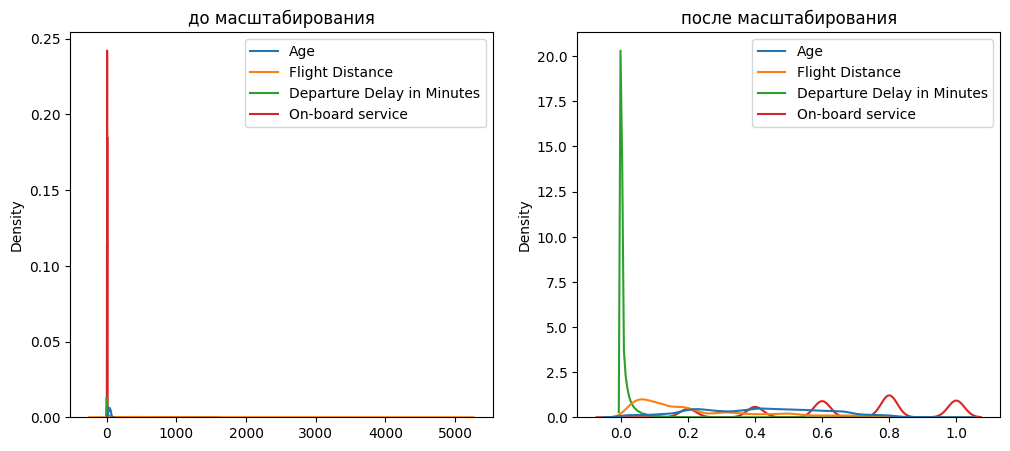

In [ ]:
draw_kde(['Age', 'Flight Distance', 'Departure Delay in Minutes', 'On-board service'], data3, data_cs31_scaled, 'до масштабирования', 'после масштабирования')

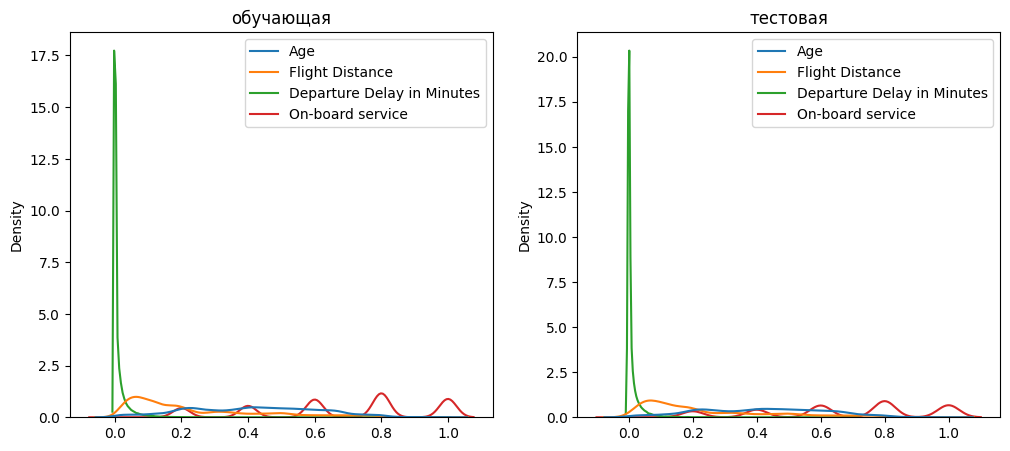

In [ ]:
draw_kde(['Age', 'Flight Distance', 'Departure Delay in Minutes', 'On-board service'], data_cs32_scaled_train, data_cs32_scaled_test, 'обучающая', 'тестовая')

В этом методе также поменялась форма исходного распределения, значения получились в диапазоне [0,1]

### Масштабирование по медиане

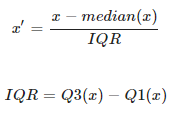

In [ ]:
cs41 = RobustScaler()
data_cs41_scaled_temp = cs41.fit_transform(data3_without_satisfaction)
data_cs41_scaled = arr_to_df(data_cs41_scaled_temp)

cs42 = RobustScaler()
cs42.fit(data3_train_without_satisfaction)
data_cs42_scaled_train_temp = cs42.transform(data3_train_without_satisfaction)
data_cs42_scaled_test_temp = cs42.transform(data3_test_without_satisfaction)

data_cs42_scaled_train = arr_to_df(data_cs42_scaled_train_temp)
data_cs42_scaled_test = arr_to_df(data_cs42_scaled_test_temp)

Графики:

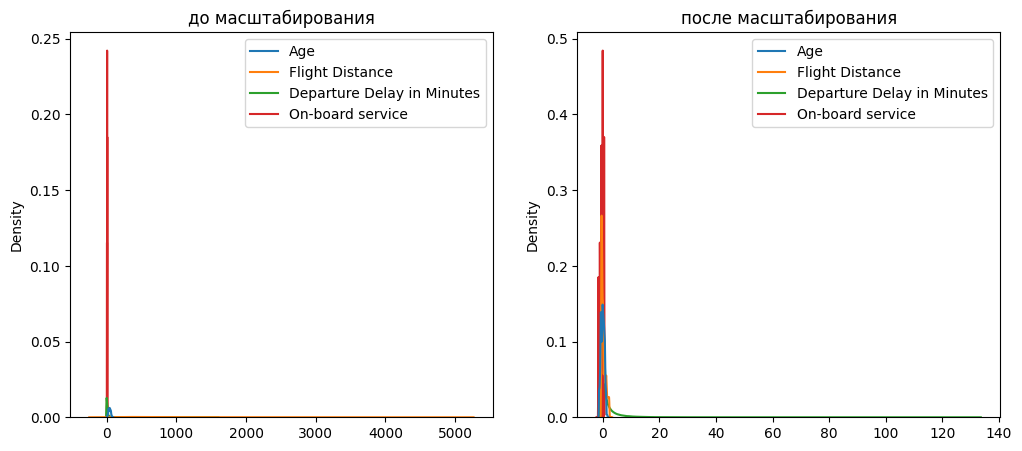

In [ ]:
draw_kde(['Age', 'Flight Distance', 'Departure Delay in Minutes', 'On-board service'], data3, data_cs41_scaled, 'до масштабирования', 'после масштабирования')

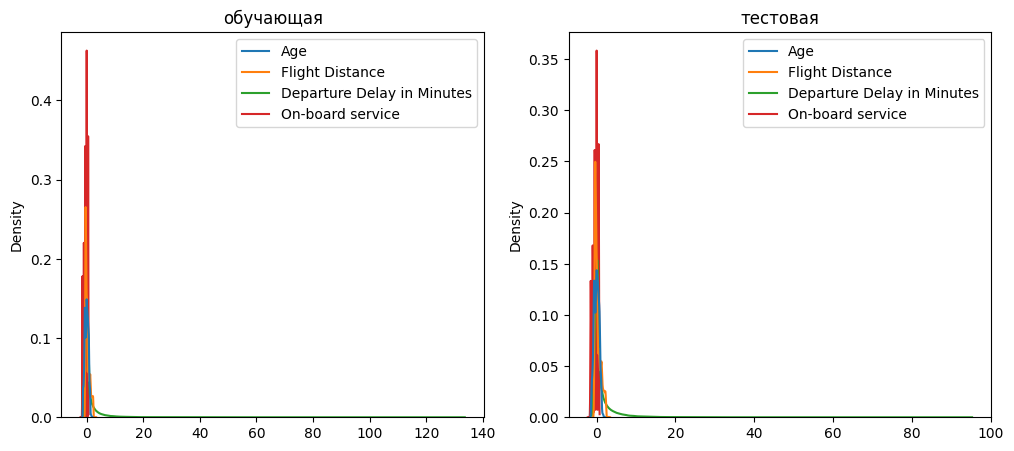

In [ ]:
draw_kde(['Age', 'Flight Distance', 'Departure Delay in Minutes', 'On-board service'], data_cs42_scaled_train, data_cs42_scaled_test, 'обучающая', 'тестовая')

В этом методе также поменялась форма исходного распределения, значения остались в том же диапазоне. Отличие данного метода еще в том, что здесь устраняются выбросы

### Масштабирование по максимальному значению

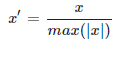

In [ ]:
cs51 = MaxAbsScaler()
data_cs51_scaled_temp = cs51.fit_transform(data3_without_satisfaction)
data_cs51_scaled = arr_to_df(data_cs51_scaled_temp)

cs52_mas = MaxAbsScaler()
cs52_mean = StandardScaler(with_mean=True, with_std=False)
cs52_mas.fit(data3_train_without_satisfaction)
cs52_mean.fit(data3_train_without_satisfaction)
data_cs52_scaled_train_temp = cs52_mas.transform(cs52_mean.transform(data3_train_without_satisfaction))
data_cs52_scaled_test_temp = cs52_mas.transform(cs52_mean.transform(data3_test_without_satisfaction))

data_cs52_scaled_train = arr_to_df(data_cs52_scaled_train_temp)
data_cs52_scaled_test = arr_to_df(data_cs52_scaled_test_temp)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MaxAbsScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MaxAbsScaler was fitted with feature names
  warnings.warn(


Графики:

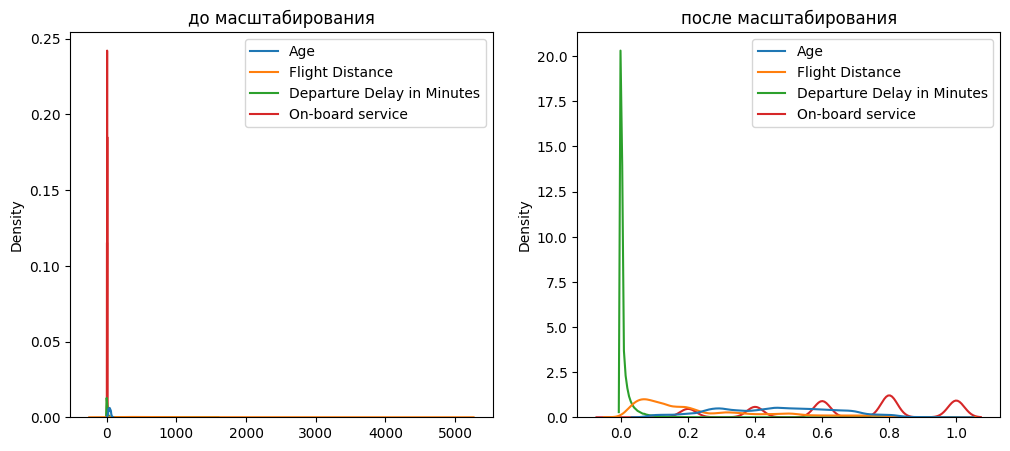

In [ ]:
draw_kde(['Age', 'Flight Distance', 'Departure Delay in Minutes', 'On-board service'], data3, data_cs51_scaled, 'до масштабирования', 'после масштабирования')

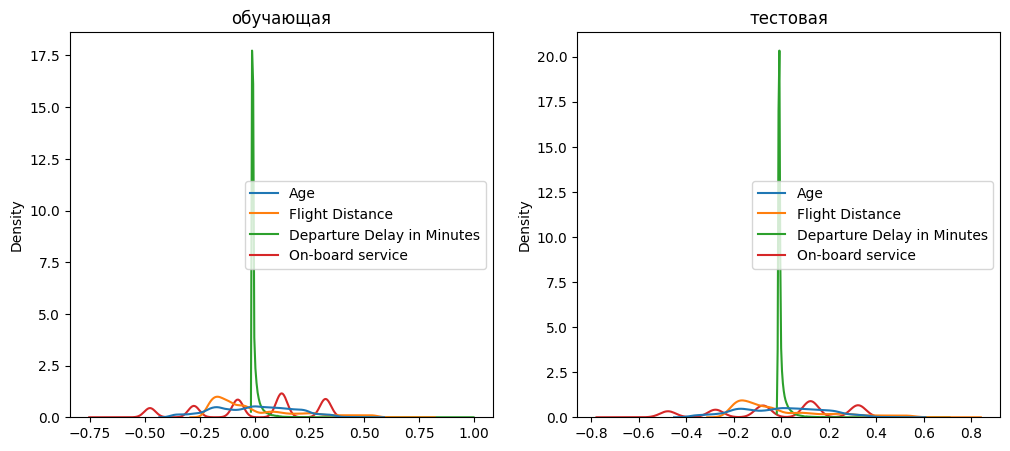

In [ ]:
draw_kde(['Age', 'Flight Distance', 'Departure Delay in Minutes', 'On-board service'], data_cs52_scaled_train, data_cs52_scaled_test, 'обучающая', 'тестовая')

В этом методе также поменялась форма исходного распределения, значения получились в диапазоне [-1,1]. При этом, здесь не центрируется ср. значение

## Обработка выбросов для числовых признаков

### Анализ набора

Перед обработкой выбросов сначала проверим распределение данных набора. На основе графиков, выводимых для масштабирования, можно сказать, что в обработке выбросов нуждаются столбцы 'Departure Delay in Minutes', Arrival Delay in Minutes - с ними и будем работать.

In [ ]:
x_col_list = ['Departure Delay in Minutes', 'Arrival Delay in Minutes']

In [ ]:
def diagnostic_plots(df, variable, title):
    fig, ax = plt.subplots(figsize=(10,7))
    # гистограмма
    plt.subplot(2, 2, 1)
    df[variable].hist(bins=30)
    ## Q-Q plot
    plt.subplot(2, 2, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    # ящик с усами
    plt.subplot(2, 2, 3)
    sns.violinplot(x=df[variable])
    # ящик с усами
    plt.subplot(2, 2, 4)
    sns.boxplot(x=df[variable])
    fig.suptitle(title)
    plt.show()

<ipython-input-303-766c933c159f>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 2, 1)


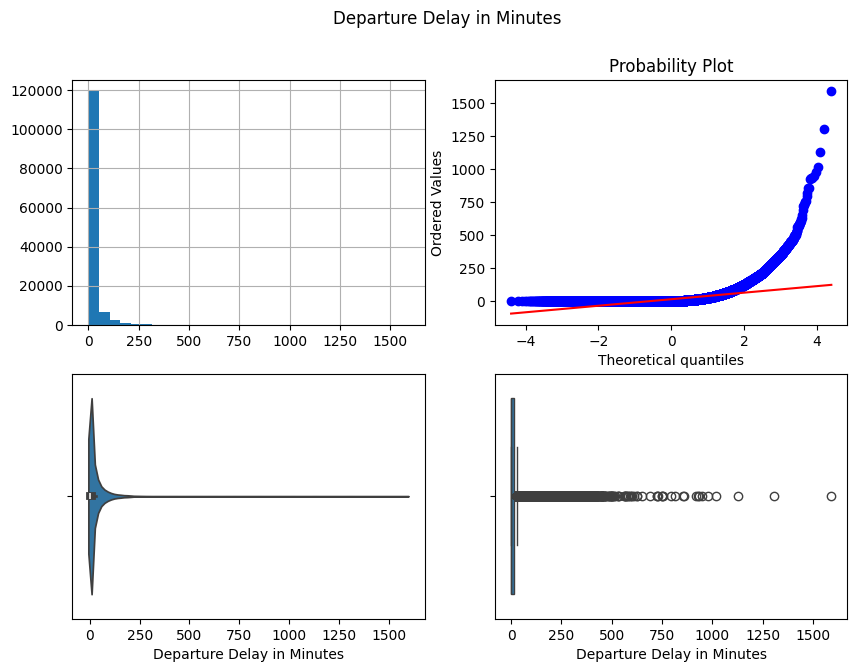

In [ ]:
diagnostic_plots(data3, 'Departure Delay in Minutes', 'Departure Delay in Minutes')

<ipython-input-303-766c933c159f>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 2, 1)


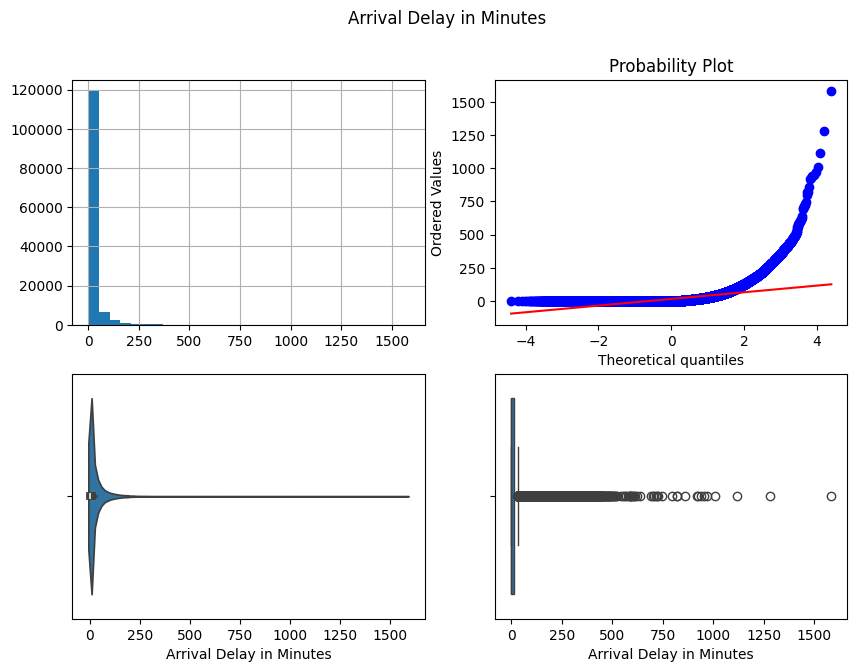

In [ ]:
diagnostic_plots(data3, 'Arrival Delay in Minutes', 'Arrival Delay in Minutes')

По графикам видим, что распределение столбца сильно смещается влево и есть выбросы при очень больших задержках полета. Скорее всего, эти задержки соответствуют каким-то происшествиям, которые привели к сильной задержке рейса (или прибытия в пункт назначения). Но такие задержки не должны влиять на общую оценку рейса.

В нашем случае распределение ассиметричное, поэтому для устранения выбросов будем использовать метод межквартильного размаха. Значение К возьмем как 5

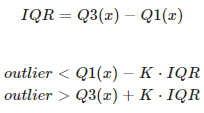

Функция вычисления верхней и нижней границы выбросов:

In [ ]:
def get_outlier_boundaries(df, col):
  K = 5
  IQR = df[col].quantile(0.75) - df[col].quantile(0.25)
  lower_boundary = df[col].quantile(0.25) - (K * IQR)
  upper_boundary = df[col].quantile(0.75) + (K * IQR)

  return lower_boundary, upper_boundary

### Удаление выбросов

<ipython-input-303-766c933c159f>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 2, 1)


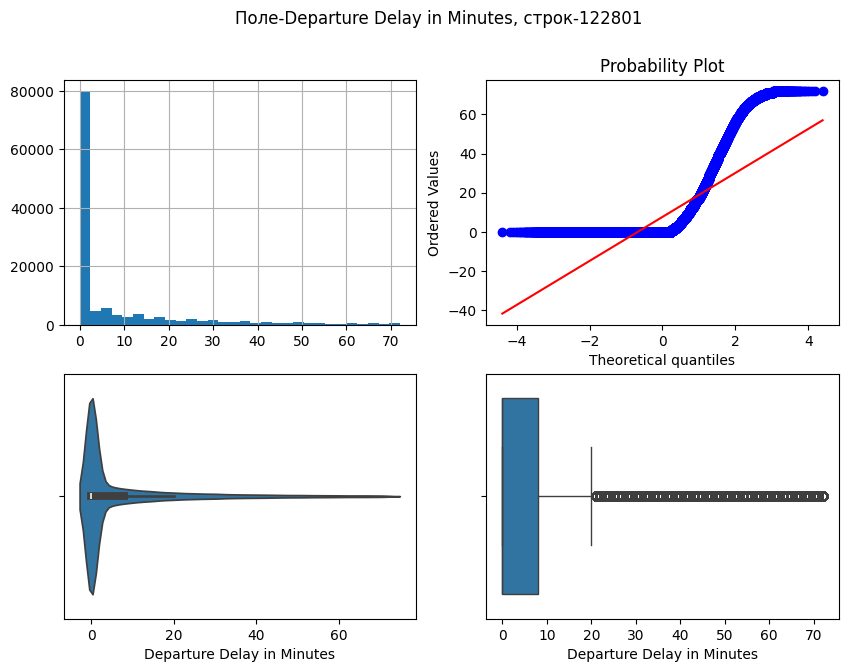

<ipython-input-303-766c933c159f>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 2, 1)


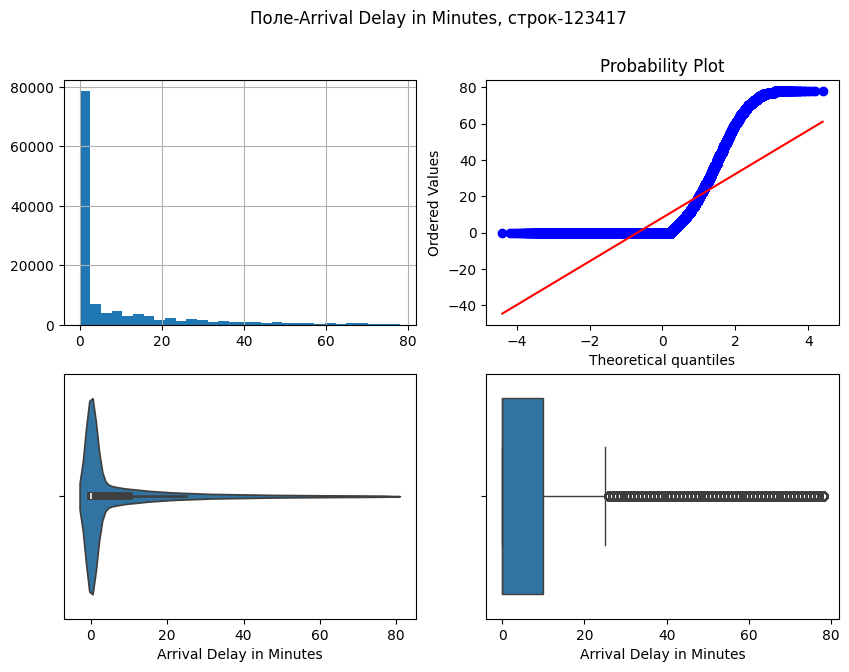

In [ ]:
for col in x_col_list:
  lower_boundary, upper_boundary = get_outlier_boundaries(data3, col)

  # Флаги для удаления выбросов
  outliers_temp = np.where(data3[col] > upper_boundary, True,
                            np.where(data3[col] < lower_boundary, True, False))

  # Удаление данных на основе флага
  data3_trimmed = data3.loc[~(outliers_temp), ]
  title = 'Поле-{}, строк-{}'.format(col, data3_trimmed.shape[0])
  diagnostic_plots(data3_trimmed, col, title)

В целом, значения немного выровнялись. При подборе больших значений К, распределение постепенно возвращалась к исходному, при малых - на графике Q-Q plot наблюдались большие расхождения. Поэтому оставили К как 5

### Замена выбросов

<ipython-input-303-766c933c159f>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 2, 1)


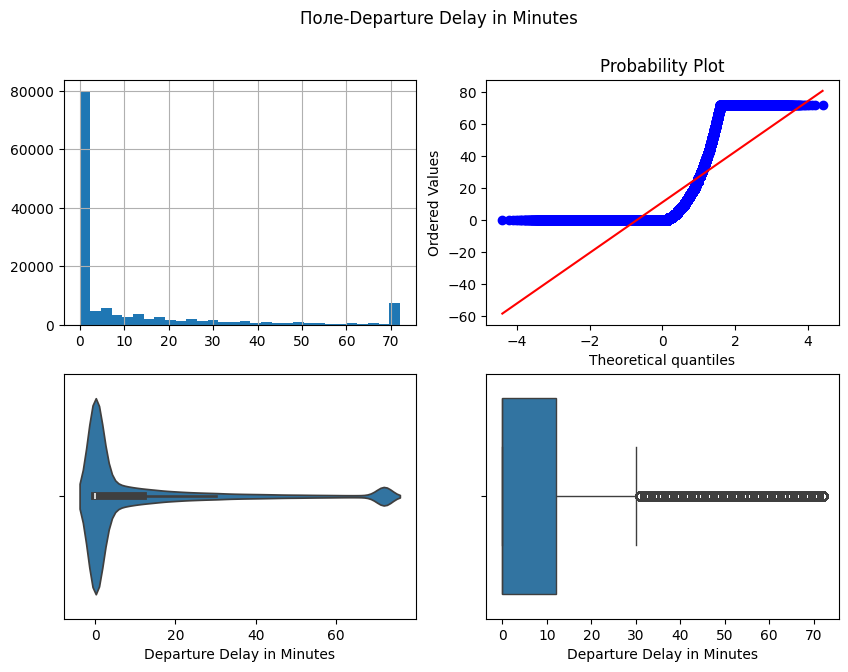

<ipython-input-303-766c933c159f>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 2, 1)


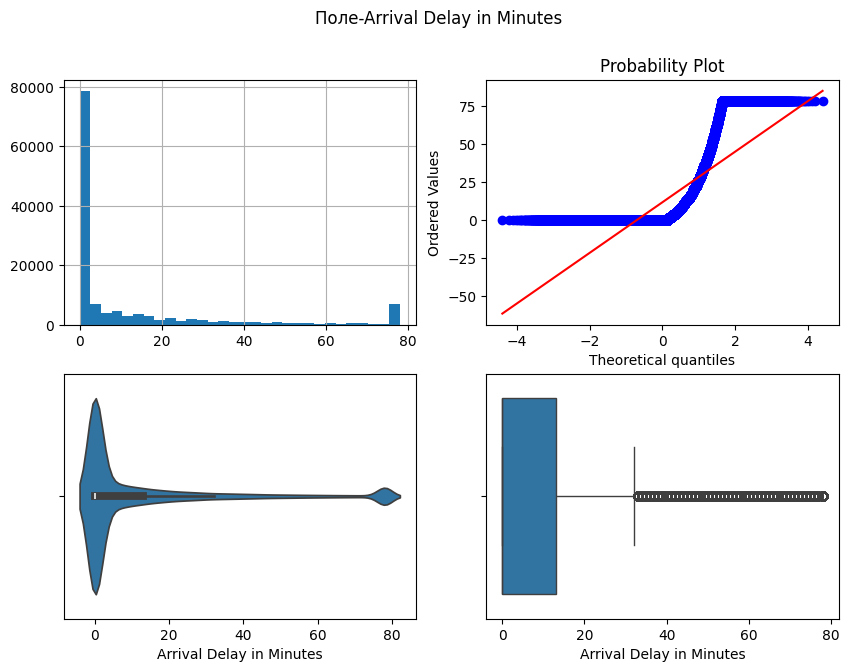

In [ ]:
data3_changed = data3.copy(deep=True)

for col in x_col_list:
  lower_boundary, upper_boundary = get_outlier_boundaries(data3, col)

  # Изменение данных
  data3_changed[col] = np.where(data3_changed[col] > upper_boundary, upper_boundary,
                            np.where(data3_changed[col] < lower_boundary, lower_boundary, data3_changed[col]))
  title = 'Поле-{}'.format(col)
  diagnostic_plots(data3_changed, col, title)

## Обработка нестандартных признаков

### Описание датасета EaseMyTrip Flight Fare Travel Listings

Обрабатывать нестандартные признаки будем для набора c ценами авиабилетов. Здесь присутствуют различные нестандартные форматы дат и времени, которые необходимо обработать.

In [ ]:
data4.head()

,Uniq Id,Crawl Timestamp,Source,Layover1,Layover2,Layover3,Destination,Flight Operator,Flight Number,Departure Date,Departure Time,Arrival Date,Arrival Time,Total Time,Number Of Stops,Fare
0,53f192419756cfa95baa4745067354f5,2020-04-01 01:23:42 +0000,Delhi,Patna,NaN,NaN,Guwahati,SpiceJet|SpiceJet,SG-8751|SG-426,23Apr2020,13:10,23Apr2020,22:00,08h 50m,1,4378.0
1,7bb845050e88cc6a4f17abf24794c73b,2020-04-01 00:59:51 +0000,Mumbai,Bangalore,Delhi,NaN,Kochi,Vistara|Vistara|Vistara,UK-851|UK-812|UK-885,18Apr2020,07:00,18Apr2020,19:10,12h 10m,2,7465.0
2,c9a84cc24d8a350eb41555c7bb76def6,2020-04-01 00:56:35 +0000,Ahmedabad,Delhi,Kolkata,NaN,Guwahati,Air India|Air India|Air India,AI-18|AI-401|AI-729,25Apr2020,07:10,26Apr2020,11:05,27h 55m,2,6179.0
3,0c0a87ac2229b8c3f1b322baf1fc9f4e,2020-04-01 00:42:35 +0000,Kolkata,Delhi,NaN,NaN,Kochi,SpiceJet|SpiceJet,SG-254|SG-8561,16Apr2020,18:00,17Apr2020,11:10,17h 10m,1,5226.0
4,b8f8af12fd6d9bf2f24389f26488478c,2020-04-01 01:52:13 +0000,Indore,Mumbai,NaN,NaN,Chennai,Indigo|Indigo,6E-5321|6E-323,18Apr2020,07:25,18Apr2020,13:35,06h 10m,1,3333.0


Размер набора:

In [ ]:
data4.shape

(30000, 16)

Обработанный далее набор будем записывать в эту переменнную:

In [ ]:
data4_normal_formats = data4.copy(deep=True)

### Обработка форматов столбцов

Сконвертируем дату и время для столбцов 'Departure Date', 'Arrival Date' в формат datetime, при этом объединив время и дату:

In [ ]:
data4_normal_formats['departure_datetime'] = data4.apply(lambda x: pd.to_datetime(x['Departure Date'] + x['Departure Time'], format='%d%b%Y%H:%M'), axis=1)
data4_normal_formats['arrival_datetime'] = data4.apply(lambda x: pd.to_datetime(x['Arrival Date'] + x['Arrival Time'], format='%d%b%Y%H:%M'), axis=1)

In [ ]:
data4_normal_formats=data4_normal_formats.drop(columns=['Departure Date', 'Departure Time', 'Arrival Date', 'Arrival Time'],axis=1)

Таким образом мы получаем 2 столбца в формате datetime, с которыми можно дальше удобно работать. При этом дата и время у нас теперь в одном столбце

Например, можем вычислить общее время полета:

In [ ]:
datetime_diff = data4_normal_formats['arrival_datetime'] - data4_normal_formats['departure_datetime']

In [ ]:
def calc_total_minutes(x):
  return x.total_seconds() / 60

total_minutes_col = datetime_diff.apply(calc_total_minutes)
total_minutes_col

0         530.0
1         730.0
2        1675.0
3        1030.0
4         370.0
          ...  
29995     525.0
29996     785.0
29997    1510.0
29998    1940.0
29999     135.0
Length: 30000, dtype: float64

Вычисленный столбец аналогичен столбцу Total Time из нашего набора. Выходит, мы провели вычисления верно.

Также сконвентируем столбец 'Crawl Timestamp' в формат datetime:

In [ ]:
data4_normal_formats['Crawl Timestamp'] = data4.apply(lambda x: pd.to_datetime(x['Crawl Timestamp'], format='%Y-%m-%d %H:%M:%S %z'), axis=1)

Столбец 'Total Time' переведем в минуты:

In [ ]:
def total_time_to_minutes(val):
  hours, minutes = re.findall(r"\d+", val)
  return (int(hours) * 60 + int(minutes))

data4_normal_formats['Total Time'] = data4.apply(lambda x: total_time_to_minutes(x['Total Time']), axis=1)

In [ ]:
data4_normal_formats.head()

,Uniq Id,Crawl Timestamp,Source,Layover1,Layover2,Layover3,Destination,Flight Operator,Flight Number,Total Time,Number Of Stops,Fare,departure_datetime,arrival_datetime
0,53f192419756cfa95baa4745067354f5,2020-04-01 01:23:42+00:00,Delhi,Patna,NaN,NaN,Guwahati,SpiceJet|SpiceJet,SG-8751|SG-426,530,1,4378.0,2020-04-23 13:10:00,2020-04-23 22:00:00
1,7bb845050e88cc6a4f17abf24794c73b,2020-04-01 00:59:51+00:00,Mumbai,Bangalore,Delhi,NaN,Kochi,Vistara|Vistara|Vistara,UK-851|UK-812|UK-885,730,2,7465.0,2020-04-18 07:00:00,2020-04-18 19:10:00
2,c9a84cc24d8a350eb41555c7bb76def6,2020-04-01 00:56:35+00:00,Ahmedabad,Delhi,Kolkata,NaN,Guwahati,Air India|Air India|Air India,AI-18|AI-401|AI-729,1675,2,6179.0,2020-04-25 07:10:00,2020-04-26 11:05:00
3,0c0a87ac2229b8c3f1b322baf1fc9f4e,2020-04-01 00:42:35+00:00,Kolkata,Delhi,NaN,NaN,Kochi,SpiceJet|SpiceJet,SG-254|SG-8561,1030,1,5226.0,2020-04-16 18:00:00,2020-04-17 11:10:00
4,b8f8af12fd6d9bf2f24389f26488478c,2020-04-01 01:52:13+00:00,Indore,Mumbai,NaN,NaN,Chennai,Indigo|Indigo,6E-5321|6E-323,370,1,3333.0,2020-04-18 07:25:00,2020-04-18 13:35:00


## Отбор признаков

### Метод фильтрации (filter method)

Отбор будем проводить для датасета Air_Traffic_Passenger_Statistics из 1 лабораторной

#### Обработка датасета Air_Traffic_Passenger_Statistics

Нулевые значения всего в 2х колонках, но для анализа мы их использовать не будем. Вырежем колонки, которые не будем использовать:

In [ ]:
data=data.drop(columns=['index','Operating Airline IATA Code','Published Airline IATA Code'],axis=1)

In [ ]:
data.isnull().sum().sum()

0

In [ ]:
data_enc = data.copy(deep=True)
for col in ([c for c in data.columns if data[c].dtype == 'O'] + ['Activity Period']):
  le = LabelEncoder()
  data_enc[col] = le.fit_transform(data_enc[col])

#### Выполнение фильтрации

Будем использовать метод, основанный на корреляции. То есть найдем группы коррелирующих признаков, на основе чего сможем понять, какие признаки можем удалить

In [ ]:
data_enc_copy = data_enc.copy(deep=True)

Формирование DataFrame с сильными корреляциями

In [ ]:
def make_corr_df(df):
    cr = data.corr(numeric_only=True)
    cr = cr.abs().unstack()
    cr = cr.sort_values(ascending=False)
    cr = cr[cr >= 0.8]
    cr = cr[cr < 1]
    cr = pd.DataFrame(cr).reset_index()
    cr.columns = ['f1', 'f2', 'corr']
    return cr

Обнаружение групп коррелирующих признаков

In [ ]:
 def corr_groups(cr):
    grouped_feature_list = []
    correlated_groups = []

    for feature in cr['f1'].unique():
        if feature not in grouped_feature_list:
            # находим коррелирующие признаки
            correlated_block = cr[cr['f1'] == feature]
            cur_dups = list(correlated_block['f2'].unique()) + [feature]
            grouped_feature_list = grouped_feature_list + cur_dups
            correlated_groups.append(cur_dups)
    return correlated_groups

Группы коррелирующих признаков

In [ ]:
corr_groups(make_corr_df(data))

[['Adjusted Passenger Count', 'Passenger Count'], ['Year', 'Activity Period']]

Таким образом, можно сделать вывод о том, что столбцы 'Passenger Count' и 'Activity Period' стоит удалить.

### Метод обертывания (wrapper method)

Сделаем полный перебор набора Airline Passenger Satisfaction с разным числом признаков и определим, какие вариации признаков лучше всего

Будем перебирать только часть набора, т.к. весь набор перебирается очень долго (много часов)

In [ ]:
data3_part = data3_without_satisfaction.copy(deep=True)[data3_without_satisfaction.columns[0:5]]

In [ ]:
knn = KNeighborsClassifier(n_neighbors=3)

In [ ]:
efs1 = EFS(knn,
           min_features=3,
           max_features=4,
           scoring='accuracy',
           print_progress=True,
           cv=5)

efs1 = efs1.fit(data3_part, data3_Y)

print('Best accuracy score: %.2f' % efs1.best_score_)
print('Best subset (indices):', efs1.best_idx_)
print('Best subset (corresponding names):', efs1.best_feature_names_)

Features: 15/15

Best accuracy score: 0.81
Best subset (indices): (0, 2, 3)
Best subset (corresponding names): ('Age', 'Inflight wifi service', 'Departure/Arrival time convenient')


Таким образом, получили лучший набор признаков при их количестве 3-4 из 5

### Метод вложений (embedded method)

Будем использовать метод логистической регрессии для решения задачи классификации набора Airline Passenger Satisfaction

In [ ]:
# Используем L1-регуляризацию
e_lr1 = LogisticRegression(C=1000, solver='liblinear', penalty='l1', max_iter=500, random_state=1)
e_lr1.fit(data3_without_satisfaction, data3_Y)

# Коэффициенты регрессии
e_lr1.coef_

array([[ 5.05395242e-03,  5.46604394e-04,  3.85759506e-01,
        -2.98822285e-01, -1.64012337e-01,  1.08797580e-01,
        -5.68178111e-02,  7.59002231e-01,  1.12547545e-01,
         2.59946067e-01,  2.60491007e-01,  3.23632493e-01,
         7.19304252e-02,  2.28922985e-01,  2.68821055e-02,
         8.42771050e-02,  2.43052324e-03, -6.25292180e-03]])

Посмотрим, какие признаки были отобраны:

In [ ]:
sel_e_lr1 = SelectFromModel(e_lr1)
sel_e_lr1.fit(data3_without_satisfaction, data3_Y)
sel_e_lr1.get_support()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True])

Вышло, что все признаки важны для набора